In [2]:
# predictions_file_path = "command_r_attributions_natural_questions_new.jsonl"
predictions_file_path = "/home/wallat/RAG/data/predictions/CR+_2024/results.jsonl"

## Data Loading Utils

In [3]:
import json


with open(predictions_file_path, "r") as f:
    predictions = [json.loads(line) for line in f]

print(predictions[0].keys())

dict_keys(['id', 'question', 'answer', 'retrieved_docs', 'selected_docs'])


In [4]:
predictions[2]['answer']

"Relevant Documents: 0,1,2,3,4\nCited Documents: 0,1,2,3,4\nAnswer: Deer shed their antlers annually. This is known as'shed hunting' or 'bone picking'.\nGrounded answer: Deer <co: 0>shed their antlers annually.</co: 0> This is known as <co: 1>'shed hunting'</co: 1> or <co: 1>'bone picking'</co: 1>."

In [5]:
# get all invidual citations for each claim

grounded_answer = predictions[2]['answer'].split('Grounded answer: ')[1]
grounded_answer

"Deer <co: 0>shed their antlers annually.</co: 0> This is known as <co: 1>'shed hunting'</co: 1> or <co: 1>'bone picking'</co: 1>."

In [6]:
import regex as re

def extract_citations(grounded_answer):

    pattern = r'<co: ([\d,]+)>(.*?)<\/co: \1>'
    matches = re.findall(pattern, grounded_answer)
    citations = []

    for match in matches:
        documents = match[0]
        claim = match[1]
        citations.append({'claim': claim, 'documents': documents.split(',')})
        # print(f'Claim: "{claim}", provenance document: {documents}')

    return citations

citations = extract_citations(grounded_answer)
citations

[{'claim': 'shed their antlers annually.', 'documents': ['0']},
 {'claim': "'shed hunting'", 'documents': ['1']},
 {'claim': "'bone picking'", 'documents': ['1']}]

In [7]:
import nltk
from typing import List

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/wallat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
def split_into_sentences(text) -> List[str]:
    # Step 1: Remove the tags using regex
    text = re.sub(r'<co: [\d,]+>(.*?)<\/co: [\d,]+>', r'\1', text)

    # Step 2: Tokenize the cleaned text into sentences
    sentences = nltk.sent_tokenize(text)
    return sentences

sentences = split_into_sentences(grounded_answer)

for i, sentence in enumerate(sentences):
    print(f"Sentence {i+1}: {sentence}")

Sentence 1: Deer shed their antlers annually.
Sentence 2: This is known as 'shed hunting' or 'bone picking'.


In [9]:
def add_source_sentence_to_citations(grounded_answer, citations):

    sentences = split_into_sentences(grounded_answer)

    for citation in citations:
        # Match claim back to one of the sentences
        # print(f"Looking for claim '{citation['claim']}' in the sentences")
        selected_sentence_id = -1
        for i, sentence in enumerate(sentences):
            # print("Current sentence: ", sentence)
            if citation['claim'] in sentence:
                citation['sentence'] = sentence
                selected_sentence_id = i
                break
        if selected_sentence_id > 0:
            del sentences[:i]
        elif selected_sentence_id == -1:
            raise Exception(f"Claim '{citation['claim']}' not found in any of the sentences")
        # print(citation)
    return citations

citations = add_source_sentence_to_citations(grounded_answer, citations)

In [10]:
num_attributions = 0
num_correct_citations = 0
wrong_citations = []
all_citations = []

citations_by_question = []

for prediction in predictions:
    print('\n\n\nQuestion:', prediction['question'])
    
    try:
        grounded_answer = prediction['answer'].split('Grounded answer: ')[1]
        print('Grounded answer:', grounded_answer)
        # print("\n")

        citations = extract_citations(grounded_answer)
        citations = add_source_sentence_to_citations(grounded_answer, citations)

        citations_by_question.append({'prediction': prediction, 'citations': citations})

        for citation in citations:
            print(f"\nSource sentence: {citation['sentence']}")
            print(f"Claim: '{citation['claim']}'")
            print(f"Cited documents: {citation['documents']}")
            print('---')
            for attribution in citation['documents']:
                num_attributions += 1
                print(f"Cited document {attribution}: \n{prediction['selected_docs'][int(attribution)]}")
                print('---')
                # if citation['claim'] in prediction['selected_docs'][int(attribution)]:
                #     num_correct_citations += 1
                # else:
                #     wrong_citations.append({'claim': citation['claim'], 'document': prediction['selected_docs'][int(attribution)], 'sentence': citation['sentence']})
                all_citations.append({'claim': citation['claim'], 'doc_id': attribution, 'document': prediction['selected_docs'][int(attribution)], 'sentence': citation['sentence']})
    except Exception as e:
        print("\n\n\nThere was an error processing this QA pair")
        print(e)
        print("\n\n")
        print(prediction['answer'])





Question: what is the definition of bcc in email
Grounded answer: BCC stands for <co: 0,1,2,3,4>"blind carbon copy"</co: 0,1,2,3,4>. It <co: 0,1>allows the sender of an email to conceal the person entered in the BCC field from the other recipients.</co: 0,1> It is <co: 1>common practice to use the BCC field when addressing a very long list of recipients, or a list of recipients who should not know each other.</co: 1>

Source sentence: BCC stands for "blind carbon copy".
Claim: '"blind carbon copy"'
Cited documents: ['0', '1', '2', '3', '4']
---
Cited document 0: 
Blind carbon copy
Blind carbon copy
Blind carbon copy (abbreviated Bcc:) allows the sender of a message to conceal the person entered in the Bcc: field from the other recipients. This concept originally applied to paper correspondence and now also applies to email.
In some circumstances, the typist creating a paper correspondence must ensure that multiple recipients of such a document do not see the names of other recipient

In [11]:
print(f"Number of attributions: {num_attributions}")
print(f"Number of correct citations: {num_correct_citations}")
print(f"Number of wrong citations: {num_attributions - num_correct_citations}")
print(f"Accuracy: {num_correct_citations / num_attributions}")

Number of attributions: 10331
Number of correct citations: 0
Number of wrong citations: 10331
Accuracy: 0.0


In [12]:
wrong_citations[:2]

[]

In [13]:
def extract_grounded_answer(answer):
    grounded_answer = answer.split('Grounded answer: ')[1]
    return grounded_answer

In [14]:
import random 
import pandas as pd

data = []

sample = random.sample(citations_by_question, 50)
for ele in sample:
    question = ele['prediction']['question']
    grounded_answer = extract_grounded_answer(ele['prediction']['answer'])
    selected_docs = ele['prediction']['selected_docs']

    data.append({'question': question, 'grounded_answer': grounded_answer, 'D0': selected_docs[0], 'D1': selected_docs[1], 'D2': selected_docs[2], 'D3': selected_docs[3], 'D4': selected_docs[4]})

df = pd.DataFrame(data)
df.to_csv('sample_50_2.csv')

# citations_by_question[0]['prediction']['question']

# extract_grounded_answer(citations_by_question[0]['prediction']['answer'])

# citations_by_question[0]['prediction']['selected_docs']

In [15]:
## Sample some citations and save them to a csv file

import pandas as pd

df = pd.DataFrame(citations_by_question)
df.head()

prediction  \
0  {'id': '-4203908294749842710', 'question': 'wh...   
1  {'id': '9149758552440472471', 'question': 'an ...   
2  {'id': '-5620495892196990154', 'question': 'wh...   
3  {'id': '5317988699618286188', 'question': 'who...   
4  {'id': '3994708788434954529', 'question': 'whe...   

                                           citations  
0  [{'claim': '"blind carbon copy"', 'documents':...  
1  [{'claim': 'paid into the Social Security syst...  
2  [{'claim': 'shed their antlers annually.', 'do...  
3                                                 []  
4  [{'claim': 'Victory March', 'documents': ['1',...

### Metrics

In [16]:
# import wandb
from evaluate import load
# from src.bem_pt import init_bem_model, predict_bem
from tqdm import tqdm
import string


def split_answers_with_multiple_options(data, model_predictions, question_type):
    dataset = []

    for index in range(0, len(data)):
        row = data.iloc[index]

        try:
            question = row["Question"]
            answers = str(row["Answer"])
        except:
            # No questions in dataset -> task is event ordering or fact checking, so we take the 
            # model input as question
            question = model_predictions.iloc[index]["input"]
            answers = str(model_predictions.iloc[index]["ground_truth"])

        # answers = row["Answer"]
        if "__or__" in answers:
            answers = answers.split("__or__")
        else:
            answers = [answers]

        dataset.append(
            {
                "id": str(index),
                "question": question,
                "answers": answers,
                "type": question_type,
            }
        )

    return dataset


def convert_to_references(dataset):
    # Convert to reference format (evaluate library)
    # {'answers': {'answer_start': [97], 'text': ['1976']}, 'id': '0'}
    references = []

    for ele in dataset:
        answers = ele["answers"]
        ref = {
            "id": str(ele["id"]),
            "answers": {"answer_start": len(answers) * [0], "text": answers},
        }

        references.append(ref)

    return references


def extract_questions(dataset):
    questions = []

    for ele in dataset:
        questions.append(ele["question"])

    return questions


def convert_to_predictions(model_predictions):
    predictions = []

    for index in range(0, len(model_predictions)):
        row = model_predictions.iloc[index]

        predictions.append({"prediction_text": row["answer"], "id": str(row["q_id"])})

    # predictions[14]
    return predictions


def contains(ref, pred):
    ref = ref.lower()
    pred = pred.lower()

    ref = ref.translate(str.maketrans("", "", string.punctuation))
    pred = pred.translate(str.maketrans("", "", string.punctuation))

    return ref in pred


def compute_contains_metric(references, predictions):
    # New metric "contains answer"
    num_contains = 0
    scores = []

    print("*********************************************************** Computing contains metric ***********************************************************")

    for pred, ref in zip(predictions, references):
        print("\n\nprediction: ", pred["prediction_text"])
        print("reference: ", ref["answers"]["text"])

        try:
            predicted_answer = pred["prediction_text"].lower()
        except:
            # print(pred["prediction_text"])
            # Special character
            print("Skipped contains computation")
            continue
        ref_answers = ref["answers"]["text"]
        ref_answers = [x.lower() for x in ref_answers]
        ref_answers = [
            x.translate(str.maketrans("", "", string.punctuation)) for x in ref_answers
        ]

        predicted_answer = predicted_answer.translate(str.maketrans("", "", string.punctuation))

        print("\n\nprediction processed: ", predicted_answer)
        print("reference processed: ", ref_answers)

        contained = False
        for ref_answer in ref_answers:
            if ref_answer in predicted_answer:
                contained = True

        if contained:
            num_contains += 1
            scores.append(1)
        else:
            scores.append(0)

        print("contained: ", contained)

    return (num_contains / len(references)) * 100, scores


def compute_bemscore(references, predictions, questions):
    # The default in the paper https://arxiv.org/pdf/2202.07654.pdf​ is 0.5 - Minimal improvement
    # has been observed when directly tuning the treshold to 0.56 on the training set.
    threshold = 0.5
    preds = []
    for pred in predictions:
        preds.append(pred["prediction_text"])

    refs = []
    for ref in references:
        refs.append(ref["answers"]["text"])

    bem, tokenizer = init_bem_model()

    scores = []
    for question, references, prediction in tqdm(zip(questions, refs, preds)):

        match_score = 0
        for reference in references:
            if predict_bem(bem, question, reference, prediction, tokenizer) > threshold:
                match_score = 1

        scores.append(match_score)
    bem_score = sum(scores) / len(scores)

    return bem_score, scores


# def compute_openeval(references, predictions, questions):
#     preds = []
#     for pred in predictions:
#         preds.append(pred["prediction_text"])

#     refs = []
#     for ref in references:
#         refs.append(ref["answers"]["text"])

#     openeval_pipe = init_openeval_pipeline()

#     scores = []
#     for question, references, prediction in tqdm(zip(questions, refs, preds)):

#         match_score = 0
#         for reference in references:
#             if predict_openeval(openeval_pipe, question, reference, prediction) == 1:
#                 match_score = 1
#         scores.append(match_score)

#     openeval_score = sum(scores) / len(scores)

#     return openeval_score, scores


def compute_metrics(args, references, predictions, questions, path, single_metric=None, model_predictions=None):
    if single_metric == "squad":
        squad_metric = load("omidf/squad_precision_recall")
        return squad_metric.compute(predictions=predictions, references=references)
    elif single_metric == "contains":
        return compute_contains_metric(references, predictions)
    # elif single_metric == "OE":
    #     return compute_openeval(references, predictions, questions)
    elif single_metric == "BEM":
        return compute_bemscore(references, predictions, questions)

    else:
        # Compute all metrics
        squad_metric = load("omidf/squad_precision_recall")
        results = squad_metric.compute(predictions=predictions, references=references)
        results["contains"], contains_scores = compute_contains_metric(references, predictions)

        # results["OE_score"], oe_scores = compute_openeval(references, predictions, questions)
        results["BEM_score"], bem_scores = compute_bemscore(references, predictions, questions)        


        if model_predictions is not None:
            model_predictions["contains"] = contains_scores
            # model_predictions["OE_score"] = oe_scores
            model_predictions["BEM_score"] = bem_scores

            model_predictions.to_csv(path, index=False, sep="\t")

    return results


def evaluate(args, data, model_predictions, ds_name, question_type, path=None, single_metric=None):
    dataset = split_answers_with_multiple_options(data, model_predictions, question_type)

    references = convert_to_references(dataset)
    predictions = convert_to_predictions(model_predictions)
    questions = extract_questions(dataset)

    results = compute_metrics(args, references, predictions, questions, path, single_metric, model_predictions)

    # for key in results.keys():
    #     wandb.log({f"{ds_name} {question_type} {key}": results[key]})
    # wandb.log(results)

    return results


In [17]:
all_citations[:2]

[{'claim': '"blind carbon copy"',
  'doc_id': '0',
  'document': 'Blind carbon copy\nBlind carbon copy\nBlind carbon copy (abbreviated Bcc:) allows the sender of a message to conceal the person entered in the Bcc: field from the other recipients. This concept originally applied to paper correspondence and now also applies to email.\nIn some circumstances, the typist creating a paper correspondence must ensure that multiple recipients of such a document do not see the names of other recipients. To achieve this, the typist can: \nBULLET::::-',
  'sentence': 'BCC stands for "blind carbon copy".'},
 {'claim': '"blind carbon copy"',
  'doc_id': '1',
  'document': 'Blind carbon copy\nLET::::- Bcc: Blind carbon copy to tertiary recipients who receive the message. The primary and secondary recipients cannot see the tertiary recipients. Depending on email software, the tertiary recipients may only see their own email address in Bcc, or they may see the email addresses of all primary and seconda

In [18]:
# contains_vals = []
# # f1_vals = []
# recall_vals = []

# squad_metric = load("omidf/squad_precision_recall")

# for citation in tqdm(all_citations):
#     ref = citation['claim']
#     pred = citation['document']
#     contains_vals.append(contains(ref, pred))

#     ref = [citation['claim']]
#     pred = citation['document']
#     results = squad_metric.compute(predictions=[{"prediction_text": pred, "id": "0"}], references=[{"id": "0", "answers": {"answer_start": [0], "text": ref}}])
#     # f1_vals.append(results['f1'])
#     recall_vals.append(results['recall'])

# print(f"Contains: {sum(contains_vals) / len(contains_vals)}")
# # print(f"F1: {sum(f1_vals) / len(f1_vals)}")
# print(f"Recall: {sum(recall_vals) / len(recall_vals)}")

In [19]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch
# from tqdm import tqdm

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# model_name = "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

# premise = "Blind carbon copy\nBlind carbon copy\nBlind carbon copy (abbreviated Bcc:) allows the sender of a message to conceal the person entered in the Bcc: field from the other recipients. This concept originally applied to paper correspondence and now also applies to email.\nIn some circumstances, the typist creating a paper correspondence must ensure that multiple recipients of such a document do not see the names of other recipients. To achieve this, the typist can: \nBULLET::::-'"
# hypothesis = "BCC stands for blind carbon copy."

# def predict_NLI(premise, hypothesis):

#     input = tokenizer(premise, hypothesis, truncation=True, return_tensors="pt")
#     output = model(input["input_ids"].to(device))  # device = "cuda:0" or "cpu"
#     prediction = torch.softmax(output["logits"][0], -1).tolist()
#     label_names = ["entailment", "neutral", "contradiction"]
#     prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
#     # print(prediction)

#     return prediction

# NLI_vals = []

# for citation in tqdm(all_citations[:500]):
#     # print("\n")
#     # print(citation['sentence'])
#     # print(citation['claim'])
#     # print(citation['document'])
#     NLI_vals.append(predict_NLI(citation['claim'], citation['document']))
#     # NLI_vals.append(predict_NLI(citation['sentence'], citation['document']))


In [20]:
# NLI_vals

In [21]:
# nli_vals = []

# for val in NLI_vals:
#     # print(val)
#     judgement = max(val, key=val.get)
#     if judgement == "entailment":
#         nli_vals.append(1)
#     elif judgement == "neutral":
#         nli_vals.append(0)
#     else:
#         nli_vals.append(0)
#     # print(judgement)
#     # break

# print(f"NLI: {sum(nli_vals) / len(nli_vals)}")

In [22]:
# Two analysis options: 
# 1. Do NLI only for sentences that have only 1 claim since cheking the entire sentence with multiple claims agains one document might not be enough
# 2. Do NLI for each sentence and append all documents that were used in claims for that sentence


# TODO: Reorder the citations array so that all citations for the same sentence are together

citations_by_sentence = {}
# group citations by sentence
for citation in all_citations:
    sentence = citation['sentence']
    if sentence in citations_by_sentence.keys():
        citations_by_sentence[sentence].append(citation)
    else:
        citations_by_sentence[sentence] = [citation]

citations_by_sentence.keys()


# for i, citation in tqdm(enumerate(citations)):
#     if 

dict_keys(['BCC stands for "blind carbon copy".', 'It allows the sender of an email to conceal the person entered in the BCC field from the other recipients.', 'It is common practice to use the BCC field when addressing a very long list of recipients, or a list of recipients who should not know each other.', 'An insured status under Social Security can be described as a person who has paid into the Social Security system through payroll taxes and the amount of time they have been working in jobs covered through the Social Security system.', 'This is measured through quarters of coverage (QCs).', 'In order to be considered fully insured, a person must have at least 1 QC for each calendar year.', 'Social Security Disability Insurance (SSDI) is a', 'Deer shed their antlers annually.', "This is known as 'shed hunting' or 'bone picking'.", 'The Notre Dame fight song, also known as the Victory March, was written in 1908 by two brothers who were Notre Dame graduates.', 'Michael J. Shea, a 190

In [23]:
# NLI only for sentences with 1 claim

# TODO: This is not perfect because currently there is a 1:1 mapping between claims and docs. So if a claim cites 2 docs, the there will be 2 citations with claim, doc1 and claim, doc2.

# NLI_vals = []

# for sentence, citations in tqdm(citations_by_sentence.items()):
#     if len(citations) == 1:
#         citation = citations[0]
#         # print("\n")
#         # print(sentence)
#         # print(citation['claim'])
#         # print(citation['document'])
#         NLI_vals.append(predict_NLI(sentence, citation['document']))
#         # NLI_vals.append(predict_NLI(citation['sentence'], citation['document']))

# nli_vals = []

# for val in NLI_vals:
#     # print(val)
#     judgement = max(val, key=val.get)
#     if judgement == "entailment":
#         nli_vals.append(1)
#     elif judgement == "neutral":
#         nli_vals.append(0)
#     else:
#         nli_vals.append(0)
#     # print(judgement)
#     # break

# print(f"NLI: {sum(nli_vals) / len(nli_vals)}")

In [24]:
# 2. Do NLI for each sentence and append all documents that were used in claims for that sentence


# NLI_vals = []
# i = 0
# for sentence, citations in tqdm(citations_by_sentence.items()):
#     i += 1
#     if i > 100:
#         break
#     # print("\n")
#     # print(sentence)
#     # print(citation['claim'])
#     # print(citation['document'])
#     NLI_vals.append(predict_NLI(sentence, " ".join([citation['document'] for citation in citations])))

# nli_vals = []

# for val in NLI_vals:
#     # print(val)
#     judgement = max(val, key=val.get)
#     if judgement == "entailment":
#         nli_vals.append(1)
#     elif judgement == "neutral":
#         nli_vals.append(0)
#     else:
#         nli_vals.append(0)
#     # print(judgement)
#     # break

# print(f"NLI: {sum(nli_vals) / len(nli_vals)}")

## Attribution Statistics

In [25]:
def print_counter(counter):

    for key in sorted(counter.keys()):
        print(f"{key} {counter[key]}")

### Do all answers have a similar number of citations?

0 76
1 170
2 191
3 182
4 173
5 127
6 93
7 86
8 64
9 54
10 66
11 42
12 29
13 21
14 17
15 12
16 8
17 5
18 3
19 1
None


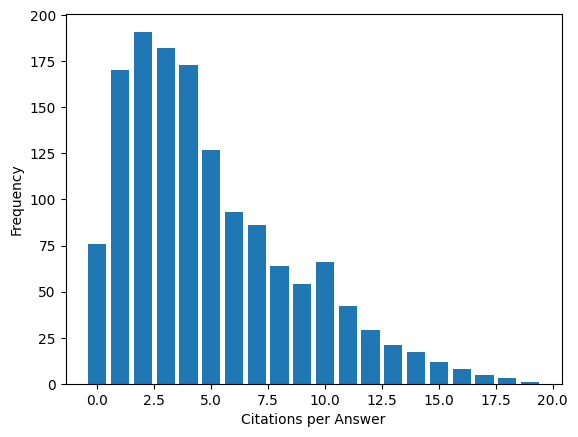

In [26]:
num_citations_per_question = []

for ele in citations_by_question:
    citations = ele['citations']

    num_citations_per_question.append(len(citations))

from collections import Counter

counter = Counter(num_citations_per_question)



import matplotlib.pyplot as plt

plt.bar(counter.keys(), counter.values())
plt.xlabel('Citations per Answer')
plt.ylabel('Frequency')

print(print_counter(counter))

### Number of sentences in answers

1 532
2 413
3 176
4 97
5 84
6 77
7 31
8 7
9 2
10 1
None


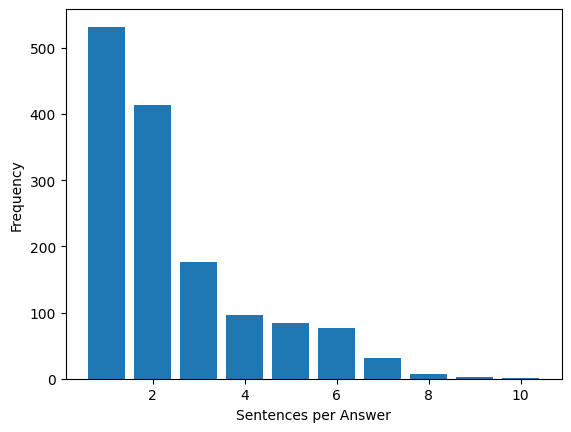

In [27]:
sentences_per_answer = []

for sentence_ele in citations_by_question:
    try:
        grounded_answer = sentence_ele['prediction']['answer'].split('Grounded answer: ')[1]

        sentences = split_into_sentences(grounded_answer)
        sentences_per_answer.append(len(sentences))
    except:
        sentences_per_answer.append(0)

counter = Counter(sentences_per_answer)

counter


plt.bar(counter.keys(), counter.values()) 
plt.xlabel('Sentences per Answer')
plt.ylabel('Frequency')

print(print_counter(counter))

### What is cited the most?

Text(0, 0.5, 'Frequency')

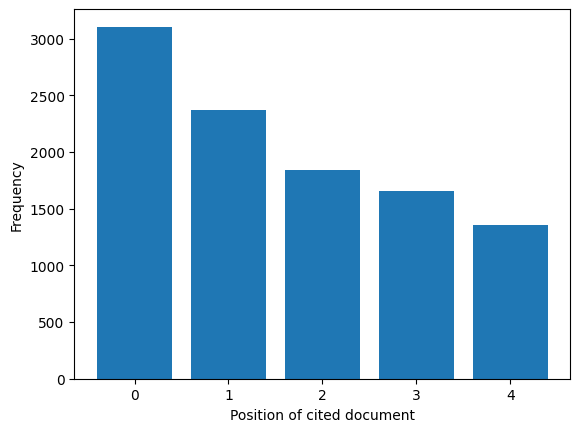

In [28]:
cited_indices = {"0": 0, "1": 0, "2": 0, "3": 0, "4": 0}

for citation in all_citations:
    cited_doc = str(citation['doc_id'])
    cited_indices[cited_doc] += 1


plt.bar(cited_indices.keys(), cited_indices.values())
plt.xlabel('Position of cited document')
plt.ylabel('Frequency')

### How long are the cited claims?

In [29]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("CohereForAI/c4ai-command-r-plus-4bit")

claims_lengths = []

for citation in all_citations:
    claim = citation['claim']
    claim_len = len(tokenizer(claim, add_special_tokens=False)['input_ids'])
    claims_lengths.append(claim_len)

# plt.hist(claims_lengths, bins=20)
# plt.xlabel('Length of claim')
# plt.ylabel('Frequency')

1 539
2 1691
3 1639
4 1573
5 1112
6 650
7 492
8 459
9 359
10 306
11 318
12 192
13 177
14 103
15 121
16 104
17 69
18 76
19 55
20 36
21 42
22 28
23 25
24 16
25 22
26 7
27 17
28 21
29 11
30 15
31 8
32 7
33 10
34 4
35 5
36 2
37 5
38 1
39 2
41 1
42 3
43 1
45 1
46 1
47 1
51 1
57 2
59 1


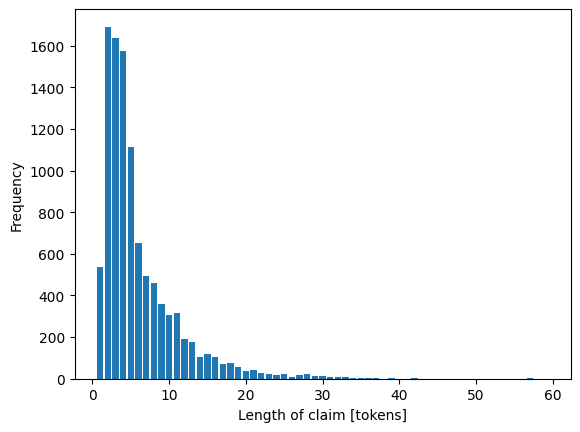

In [30]:
claims_lengths

from collections import Counter

claims_lengths_counter = Counter(claims_lengths)
claims_lengths_counter

plt.bar(claims_lengths_counter.keys(), claims_lengths_counter.values())
plt.xlabel('Length of claim [tokens]')
plt.ylabel('Frequency')

print_counter(claims_lengths_counter)

### Does the model only cite documents that it selected as relevant?
It might also cite less, also check for that


In [31]:
def get_relevant_docs(answer):
    if "Relevant Documents:" in answer:
        # Get docs that the model thought were relevant
        relevant_docs_string = answer.split("Cited Documents:")[0].split("Relevant Documents:")[1].strip()
        relevant_docs = relevant_docs_string.split(',')
        relevant_docs = [ idx for idx in relevant_docs if idx.isdigit()] 
    else:
        relevant_docs = []

    return relevant_docs

def get_supposedly_cited_docs(answer):
    if "Cited Documents:" in answer:
        # Get docs that the model said it would cite
        cited_docs_string = answer.split("Cited Documents:")[1].split("\n")[0].strip()
        supposedly_cited_docs = cited_docs_string.split(',')
        supposedly_cited_docs = [ idx for idx in supposedly_cited_docs if idx.isdigit()]
    else: 
        supposedly_cited_docs = []

    return supposedly_cited_docs


def get_actually_cited(citations):
    # get all docs that were directly cited in the answer
    cited_docs = []
    for citation in citations:
        cited_docs.extend(citation['documents'])
    cited_docs = set(cited_docs)
    
    return cited_docs


In [32]:
all_relevant = []
all_supposedly_cited = []
all_actually_cited = []

matches_relevant = []
matches_cited = []

num_nothing_cited = 0

for ele in citations_by_question:

    relevant_docs = get_relevant_docs(ele['prediction']['answer'])    
    all_relevant.append(relevant_docs)
    
    supposedly_cited_docs = get_supposedly_cited_docs(ele['prediction']['answer'])
    all_supposedly_cited.append(supposedly_cited_docs)


    cited_docs = get_actually_cited(ele['citations'])
    all_actually_cited.append(cited_docs)

    num_nothing_cited += 1 if len(cited_docs) == 0 else 0

    if len(relevant_docs) == 0 and len(cited_docs) == 0:
        matches_relevant.append(False)
    else:
        # are all relevant docs also cited?
        matches_relevant.append(set(relevant_docs) == cited_docs)
        # if matches_relevant[-1] == False:
            # print(ele['prediction']['question'])
            # print(ele['prediction']['answer'])
            # print("Rele: ", relevant_docs)
            # print("Cited (aggregated): ", cited_docs)
            # print("Cited (individual): ")
            # for citation in ele['citations']:
            #     print(citation['documents'])

    if len(supposedly_cited_docs) == 0 and len(cited_docs) == 0:
        matches_cited.append(False)
    else:
        # are all docs said to be cited actually cited?
        matches_cited.append(set(supposedly_cited_docs) == cited_docs)

print(matches_relevant)
print(f"Number of questions: {len(matches_relevant)}")
print(f"Number of questions where all relevant docs were cited: {sum(matches_relevant)}")

print("Num nothing cited: ", num_nothing_cited)

# plt.hist(matches)
# plt.xlabel('Position of cited document')
# plt.ylabel('Frequency')

[True, False, False, False, True, False, True, True, False, True, True, False, True, True, True, False, False, False, False, True, True, False, False, True, True, False, True, True, True, True, True, True, True, False, True, True, True, True, True, False, False, False, True, False, False, False, False, True, False, False, False, True, True, True, True, True, False, True, True, False, False, False, False, True, True, True, False, True, True, True, False, True, False, False, True, False, False, False, False, True, False, True, True, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, True, True, False, False, False, True, False, False, False, True, False, True, True, True, False, False, False, False, False, True, False, True, True, True, True, True, False, True, False, False, False, True, False, False, False, True, False, True, True, True, False, True, True, True, True, True, False, True, True, False, Tr

### Does the model only cite documents that it selected to be cited?

[True, False, False, False, True, False, True, True, False, True, True, False, True, True, True, False, False, False, False, True, True, False, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, True, True, False, True, False, True, False, False, False, True, True, True, True, True, False, True, True, False, False, True, False, True, True, True, False, True, True, True, False, True, False, False, True, False, True, True, False, True, False, True, True, False, False, True, True, False, True, False, True, True, False, False, False, False, False, False, True, True, False, True, False, True, True, False, False, True, True, True, False, False, True, True, True, True, True, False, False, True, False, False, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, False, True, True, False, True, False, True, True,

<BarContainer object of 3 artists>

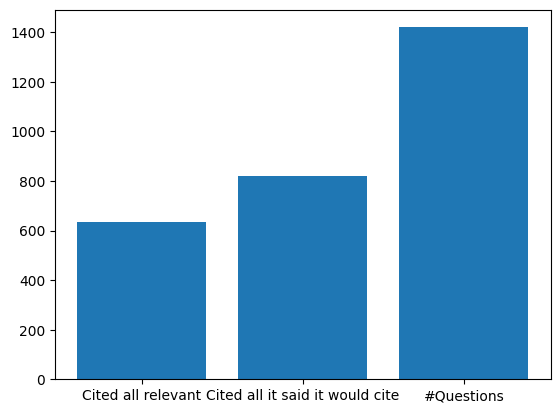

In [33]:
print(matches_cited)
print(f"Number of questions: {len(matches_cited)}")
print(f"Number of questions where all cited docs were cited: {sum(matches_cited)}")


# Data for the chart
categories = ['Cited all relevant', 'Cited all it said it would cite', "#Questions"]
values = [matches_relevant.count(True), matches_cited.count(True), len(matches_relevant)]

# Create the bar chart
plt.bar(categories, values, )

### Does the model over-cite? 
Are always all 5 documents cited? <br>
Histogram

Counter({3: 293, 2: 266, 4: 263, 5: 261, 1: 261, 0: 76})


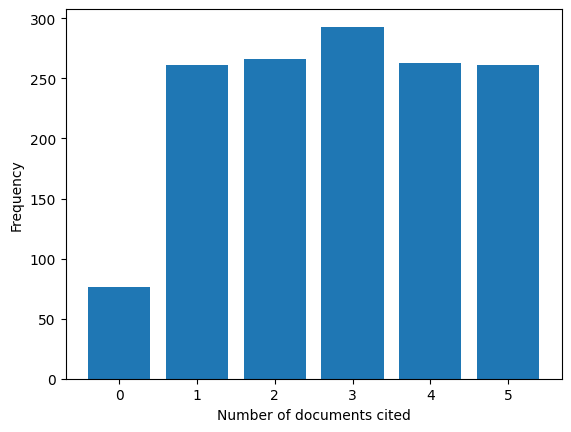

In [34]:
number_actually_cited = [len(x) for x in all_actually_cited]

actu_counter = Counter(number_actually_cited)

plt.bar(actu_counter.keys(), actu_counter.values())
plt.xlabel('Number of documents cited')
plt.ylabel('Frequency')

print(actu_counter)

Counter({5: 568, 4: 242, 3: 207, 2: 177, 1: 155, 0: 71})


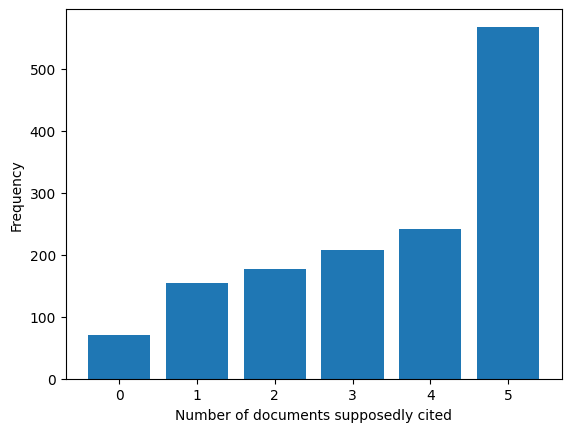

In [35]:
number_sup_cited = [len(ele) for ele in all_supposedly_cited]

counter = Counter(number_sup_cited)

# all_supposedly_cited[0]

plt.bar(counter.keys(), counter.values())
plt.xlabel('Number of documents supposedly cited')
plt.ylabel('Frequency')

print(counter)

Are always 5 documents relevant?

Counter({5: 767, 4: 207, 3: 149, 2: 123, 1: 103, 0: 71})


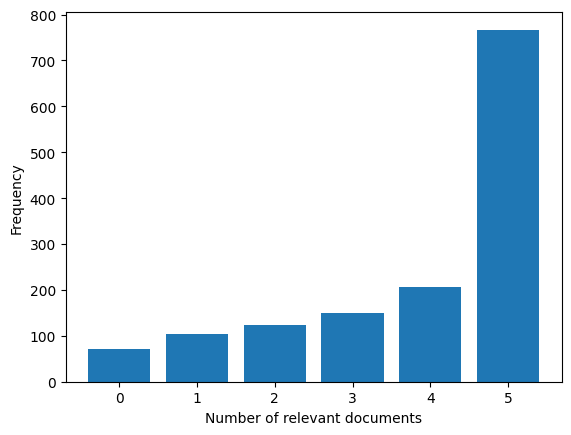

In [36]:
number_relevant = [len(ele) for ele in all_relevant]

counter = Counter(number_relevant)

plt.bar(counter.keys(), counter.values())
plt.xlabel('Number of relevant documents')
plt.ylabel('Frequency')

print(counter)


Is there a discrepancy between relevant and cited documents?

Does it cite documents it did not consider relevant?

In [37]:
num_cited_non_relevant = []
num_relevant_non_cited = []

num_cited_non_supposedly = []
num_supposedly_non_cited = []

for rels, sups, actus in zip(all_relevant, all_supposedly_cited, all_actually_cited):

    cited_not_relevant = set(actus) - set(rels)
    if len(cited_not_relevant) > 0:
        # print(cited_not_relevant)
        # print(rels)
        # print(sups)
        # print(actus)
        num_cited_non_relevant.append(len(cited_not_relevant))

    relevant_not_cited = set(rels) - set(actus)
    if len(relevant_not_cited) > 0:
        # print(relevant_not_cited)
        # print(rels)
        # print(sups)
        # print(actus)
        num_relevant_non_cited.append(len(relevant_not_cited))

    cited_non_supposedly = set(actus) - set(sups)
    if len(cited_non_supposedly) > 0:
        # print(cited_non_supposedly)
        # print(rels)
        # print(sups)
        # print(actus)
        num_cited_non_supposedly.append(len(cited_non_supposedly))

    supposedly_non_cited = set(sups) - set(actus)
    if len(supposedly_non_cited) > 0:
        # print(supposedly_non_cited)
        # print(rels)
        # print(sups)
        # print(actus)
        num_supposedly_non_cited.append(len(supposedly_non_cited))

# plt.hist(num_cited_non_relevant)

# plt.hist(num_cited_non_supposedly)


print(f"cited not relevant: {len(num_cited_non_relevant)}")
print(f"relevant not cited: {len(num_relevant_non_cited)}")
print(f"cited not supposed to be cited: {len(num_cited_non_supposedly)}")
print(f"supposed to be cited not cited: {len(num_supposedly_non_cited)}")

cited not relevant: 8
relevant not cited: 708
cited not supposed to be cited: 12
supposed to be cited not cited: 522


## Post-Rationalization Test Dataset

In [38]:
# Fix the questions and retrieved documents and adversarially change them
# This can be load from the predictions file


# Select some claim from the answer and inject this into a new document
# random docs
# relevant but uncited docs
# docs cited for other claims


# Store the information where something got changed somewhere in the dataset


In [39]:
citations_by_question[0]['citations']

[{'claim': '"blind carbon copy"',
  'documents': ['0', '1', '2', '3', '4'],
  'sentence': 'BCC stands for "blind carbon copy".'},
 {'claim': 'allows the sender of an email to conceal the person entered in the BCC field from the other recipients.',
  'documents': ['0', '1'],
  'sentence': 'It allows the sender of an email to conceal the person entered in the BCC field from the other recipients.'},
 {'claim': 'common practice to use the BCC field when addressing a very long list of recipients, or a list of recipients who should not know each other.',
  'documents': ['1'],
  'sentence': 'It is common practice to use the BCC field when addressing a very long list of recipients, or a list of recipients who should not know each other.'}]

In [40]:
def sample_random_document(citations_by_question):
    sample = random.sample(citations_by_question, 1)
    
    retrieved_docs = sample[0]['prediction']['retrieved_docs']
    return random.sample(retrieved_docs, 1)[0]


def sample_relevant_uncited_doc(question_element):
    # get all relevant docs
    relevant_docs = get_relevant_docs(question_element['prediction']['answer'])
    # get all cited docs
    cited_docs = get_actually_cited(question_element['citations'])

    # get all docs that are relevant but not cited
    relevant_not_cited = set(relevant_docs) - cited_docs

    if len(relevant_not_cited) > 0:
        doc_id = random.choice(list(relevant_not_cited))[0]

        return int(doc_id), question_element['prediction']['selected_docs'][int(doc_id)]
    else:
        return None, None


def sample_cited_for_other_claim(question_element, citation):
    # get cited docs in this claim
    cited_docs_claim = citation['documents']

    # get all cited docs
    all_cited_docs = get_actually_cited(question_element['citations'])

    # get all docs that are cited but not in this claim
    cited_not_this_claim = all_cited_docs - set(cited_docs_claim)

    if len(cited_not_this_claim) > 0:
        doc_id = random.choice(list(cited_not_this_claim))[0]

        return int(doc_id), question_element['prediction']['selected_docs'][int(doc_id)]
    else:
        return None, None

In [41]:
from tqdm import tqdm

rnd_data = []
rel_uncited_data = []
cited_other_data = []

for question_element in tqdm(citations_by_question):
    # Sample a citation 
    if len(question_element['citations']) == 0:
        continue
    citation = random.choice(question_element['citations'])

    # print(citation['claim'])

    # Sample a random document
    random_doc = sample_random_document(citations_by_question)
    # print(random_doc)
    # Add claim from citation to the docs
    random_doc += "\n" + citation['claim']
    # print(random_doc)
    # break

    selected_docs = question_element['prediction']['selected_docs'] 
    selected_docs.append(random_doc)

    rnd_data.append({
        'question': question_element['prediction']['question'],
        'selected_docs': selected_docs,
        'citation_before': citation,
        'adversarial_id': 5})

    # Sample a relevant but uncited document
    doc_id, relevant_uncited_doc = sample_relevant_uncited_doc(question_element)

    if relevant_uncited_doc is not None:
        # Add claim from citation to the docs
        relevant_uncited_doc += "\n" + citation['claim']

        selected_docs = question_element['prediction']['selected_docs']
        selected_docs[doc_id] = relevant_uncited_doc

        rel_uncited_data.append({
            'question': question_element['prediction']['question'],
            'selected_docs': selected_docs,
            'citation_before': citation,
            'adversarial_id': doc_id})
        

    # Sample a document cited for another claim
    doc_id, cited_for_other_claim = sample_cited_for_other_claim(question_element, citation)

    if cited_for_other_claim is not None:
        # Add claim from citation to the docs
        cited_for_other_claim += "\n" + citation['claim']

        selected_docs = question_element['prediction']['selected_docs']
        try:
            selected_docs[doc_id] = cited_for_other_claim
        except:
            print(doc_id)
            print(selected_docs)

        cited_other_data.append({
            'question': question_element['prediction']['question'],
            'selected_docs': selected_docs,
            'citation_before': citation,
            'adversarial_id': doc_id})

    # TODO: Which document do I remove for the random doc? Or do I just add a 6th one?

100%|██████████| 1420/1420 [00:00<00:00, 31756.73it/s]


In [42]:
len(rnd_data)
len(rel_uncited_data)
len(cited_other_data)

# Save data to csv files
# pd.DataFrame(rnd_data).to_json('post_ration_random_data.jsonl', lines=True, orient='records')
# pd.DataFrame(rel_uncited_data).to_json('post_ration_rel_uncited_data.jsonl', lines=True, orient='records')
# pd.DataFrame(cited_other_data).to_json('post_ration_cited_other_data.jsonl', lines=True, orient='records')

827

In [43]:
# Try to load the data again
# import pandas as pd

# dataset = pd.read_json("/home/wallat/RAG/post_ration_random_data.jsonl", lines=True)
# dataset.head()

# # dataset['selected_docs'][0]

# for row in dataset.iterrows():
#     row = row[1]
#     print(row['question'])
#     print(row['selected_docs'])
#     print(len(row['selected_docs']))
#     break

In [44]:
# df = pd.read_json("/home/wallat/RAG/post_ration_random_data.jsonl", lines=True)

# task_ds = []
# for row in df.iterrows():
#     row = row[1]
#     question = row['question']
#     docs = row['selected_docs']
#     citation_before = row['citation_before']
#     adversarial_id = row['adversarial_id']
#     task_ds.append({'question': question, 'docs': docs, 'citation_before': citation_before, 'adversarial_id': adversarial_id})

# task_ds[0]

### Post-Rationalization Test Eval

In [46]:
import pandas as pd

# Random
# df = pd.read_json("", lines=True)


##################### CR+ OLD
# Random 
# df = pd.read_json("/home/wallat/RAG/outputs/2024-09-30/10-16-23/results.jsonl", lines=True)

# Relevant but not cited
# df = pd.read_json("/home/wallat/RAG/outputs/2024-09-30/10-31-26/results.jsonl", lines=True)

# Cited for other claim
# df = pd.read_json("/home/wallat/RAG/outputs/2024-09-30/10-43-10/results.jsonl", lines=True)


##################### CR+ NEW
# Random
# df = pd.read_json("/home/wallat/RAG/outputs/2024-10-09/09-53-20/results.jsonl", lines=True)

# Relevant but not cited
# df = pd.read_json("/home/wallat/RAG/outputs/2024-10-09/10-01-26/results.jsonl", lines=True)

# Cited for other claim
# df = pd.read_json("", lines=True)


##################### CR+ 2024
# Random
df = pd.read_json("/home/wallat/RAG/outputs/2024-10-10/10-34-40/results.jsonl", lines=True)

# Relevant but not cited
# df = pd.read_json("/home/wallat/RAG/outputs/2024-10-10/10-41-11/results.jsonl", lines=True)

# Cited for other claim
# df = pd.read_json("/home/wallat/RAG/outputs/2024-10-10/10-41-39/results.jsonl", lines=True)

num_claim_still_there = 0
num_injected_cited = 0

for row in df.iterrows():
    prediction = row[1]
    # print('\n\n\nQuestion:', prediction['question'])
    
    try:
        grounded_answer = prediction['answer'].split('Grounded answer: ')[1]
        # print('Grounded answer:', grounded_answer)
        # print("\n")

        citations = extract_citations(grounded_answer)
        citations = add_source_sentence_to_citations(grounded_answer, citations)


        for citation in citations:
            if citation['claim'] == prediction['citation_before']['claim']:
                num_claim_still_there += 1

                print("Docs: ", citation['documents'])
                print("Adversarial id: ", prediction['adversarial_id'])
                print("In: ", str(prediction['adversarial_id']) in citation['documents'])

                if str(prediction['adversarial_id']) in citation['documents']:
                    num_injected_cited += 1

                break

        # citations_by_question.append({'prediction': prediction, 'citations': citations})
    except:
        # print("\n\n\nThere was an error processing this QA pair")
        # print(prediction['answer'])
        ...


print('Len all: ', len(df))
print('Claim still there: ', num_claim_still_there)
print('Injected cited: ', num_injected_cited)

Docs:  ['0', '2', '5']
Adversarial id:  5
In:  True
Docs:  ['0']
Adversarial id:  5
In:  False
Docs:  ['0', '1', '3', '5']
Adversarial id:  5
In:  True
Docs:  ['0', '1', '2']
Adversarial id:  5
In:  False
Docs:  ['1']
Adversarial id:  5
In:  False
Docs:  ['0', '1', '2', '3', '4']
Adversarial id:  5
In:  False
Docs:  ['2']
Adversarial id:  5
In:  False
Docs:  ['2']
Adversarial id:  5
In:  False
Docs:  ['0']
Adversarial id:  5
In:  False
Docs:  ['0', '1', '2', '3', '4']
Adversarial id:  5
In:  False
Docs:  ['0', '2', '4', '5']
Adversarial id:  5
In:  True
Docs:  ['0', '3', '4', '5']
Adversarial id:  5
In:  True
Docs:  ['3', '4']
Adversarial id:  5
In:  False
Docs:  ['1']
Adversarial id:  5
In:  False
Docs:  ['2', '3']
Adversarial id:  5
In:  False
Docs:  ['0', '2']
Adversarial id:  5
In:  False
Docs:  ['1', '3']
Adversarial id:  5
In:  False
Docs:  ['1']
Adversarial id:  5
In:  False
Docs:  ['0']
Adversarial id:  5
In:  False
Docs:  ['0']
Adversarial id:  5
In:  False
Docs:  ['3', '4']
A